# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 марта, -4 балла после 06:00 13 марта, -6 баллов после 06:00 20 марта

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [7]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()
np.sum(df_titanic["Survived"])

123

## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [8]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [9]:
# Тут стоит выполнить переобозначение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [10]:
# Например так
help(df_titanic.Sex.replace)
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.head()
df_titanic.Sex.value_counts()

Help on method replace in module pandas.core.generic:

replace(self, to_replace=None, value=None, inplace=False, limit=None, regex=False, method='pad', axis=None) method of pandas.core.series.Series instance
    Replace values given in 'to_replace' with 'value'.
    
    Parameters
    ----------
    to_replace : str, regex, list, dict, Series, numeric, or None
    
        * str or regex:
    
            - str: string exactly matching `to_replace` will be replaced
              with `value`
            - regex: regexs matching `to_replace` will be replaced with
              `value`
    
        * list of str, regex, or numeric:
    
            - First, if `to_replace` and `value` are both lists, they
              **must** be the same length.
            - Second, if ``regex=True`` then all of the strings in **both**
              lists will be interpreted as regexs otherwise they will match
              directly. This doesn't matter much for `value` since there
              are 

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [11]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [12]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [13]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
print type(emb)
print df_titanic.head()
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

<type 'numpy.ndarray'>
    PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
6             7         0       1   
10           11         1       3   
11           12         1       1   

                                                 Name  Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1   
6                             McCarthy, Mr. Timothy J    0  54.0      0   
10                    Sandstrom, Miss. Marguerite Rut    1   4.0      1   
11                           Bonnell, Miss. Elizabeth    1  58.0      0   

    Parch    Ticket     Fare Cabin Embarked  
1       0  PC 17599  71.2833   C85        C  
3       0    113803  53.1000  C123        S  
6       0     17463  51.8625   E46        S  
10      1   PP 9549  16.7000    G6        S  
11      0    113783  26.5500  C103        S  


array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [15]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [16]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]])

In [17]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [18]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [19]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [20]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [21]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

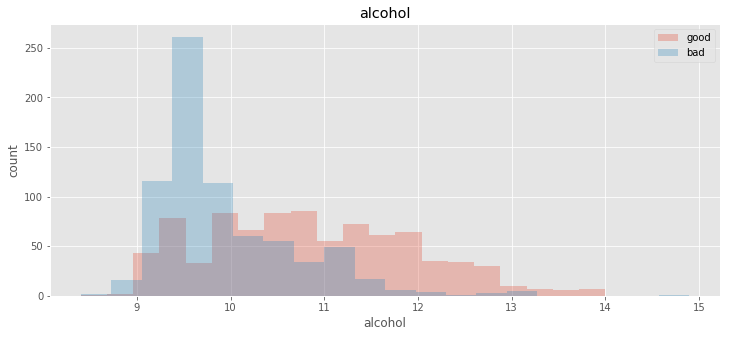

In [22]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [23]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

In [24]:
y

array([0, 0, 0, ..., 1, 0, 1])

Далее вы увидете пример реализации этого простого классификатора.

In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [26]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [27]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [28]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [29]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [30]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [31]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.</br> При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

#### Задание 1 (5 баллов)

Имплементируйте метод k-means

In [32]:
from sklearn.base import ClusterMixin

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
    def dist(self,a,b):
        if self.metric == 'euclidean':
            return np.linalg.norm(a-b)
        else:
            return None
    def closest_center(self,point):
        '''
        Для заданной точки возвращает номер кластера, к которому она ближе всего
        '''
        min_dist = self.dist(point,self.centroids[0])  #  Поначалу наименьшим будет расстояние до первого кластера
        point_label = 0
#         print "\tChecking distances..."
        for j in xrange(0,self.k):   #  Пробегаем по каждому центру
            cluster_center = self.centroids[j]  #  Получаем координаты j-го центра
            dist = self.dist(point,cluster_center)
#             print "\tDistance to cluster {} is {}".format(j,dist)
            if dist < min_dist:
                point_label = j
                min_dist = dist
        return point_label
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0]).astype(int)
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        ## Your Code Here
        # Инициализировать случайным образом центры кластеров
        n_features = X.shape[1]
        n_samples = X.shape[0]
        # Для каждой координаты генерируем случайный вектор со значениями между min и max по данной координате
        for i in xrange(0,n_features):
#             print "Lowest value for column {} is {}".format(i,np.min(X[:,i]))
#             print "Highest value for column {} is {}".format(i,np.max(X[:,i]))
#             sample = np.random.uniform(low=np.min(X[:,i]), high=np.max(X[:,i]),size=self.k)
            sample = np.random.normal(np.median(X[:,i]),size=self.k)
            self.centroids[:,i] = sample
#         for i in xrange(0,self.k):
#             print "Center of cluster {} initialized at {}".format(i, self.centroids[i])
        # Основной цикл: пока смещения центров больше eps или число шагов < max_iter, выполнять пересчет
        eps = 1e-2
        max_shift = eps+1 # пока не смещались
        step = 0
        while max_shift > eps and step < self.max_iter:
            max_shift = 0
#             print "======== Step {} =========".format(step)
            # Для каждой точки ищем расстояния до центров кластеров
            # и выбираем тот, для которого оно наименьшее
            for i in xrange(0,n_samples):
                self.labels[i] = self.closest_center(X[i])
#                 print "Closest for point {} is cluster {}".format(i, self.labels[i])
            # Проводим пересчет центров кластеров на основе полученного вектора принадлежности
            # Для каждого набора точек, принадлежащих одному кластеру, находим их среднее значение
            for i in xrange(0,self.k):  #  Проходим по каждому номеру кластера
                mask = self.labels == i  #  Булев массив принадлежности точек i-му кластеру
                if not np.any(mask):  #  Если ни одна точка не принадлежит, то точкой будет сам центр
                    cluster_points = np.expand_dims(self.centroids[i], axis=0)
                else:
                    cluster_points = X[mask]  #  выбирая все точки с номером этого кластера
                mean_point = cluster_points.mean(0)
#                 print "New mean point for cluster {} is {}".format(i,mean_point)
                shift_value = self.dist(self.centroids[i], mean_point)  #  величина сдвига центра кластера
                if shift_value > max_shift:
                    max_shift = shift_value
#                     print "New maximum shift: {}".format(max_shift)
                self.centroids[i] = mean_point
            step += 1
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        return np.array([self.closest_center(point) for point in X])

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, желатено испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

In [33]:
from sklearn.datasets import make_blobs

In [34]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

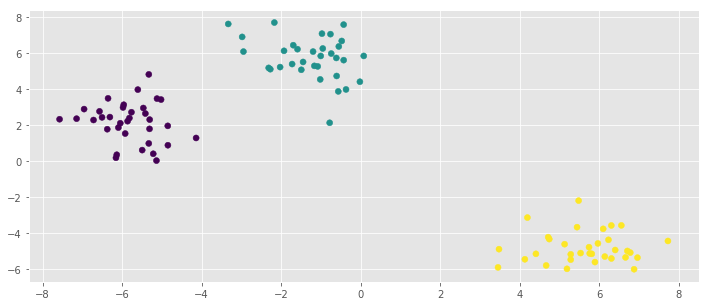

In [35]:
plt.scatter(X[:,0], X[:, 1], c=y)

#### Задание 2 (1 балл) 

Проверьте вашу имплементацию на простых данных

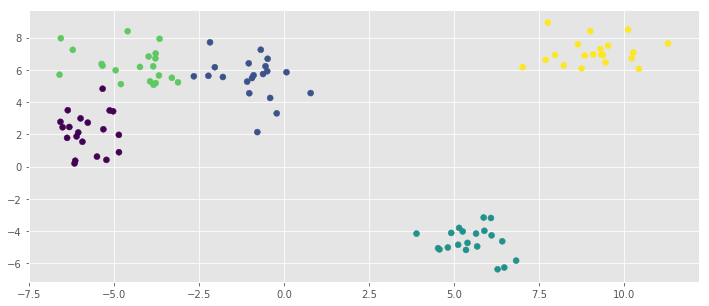

In [36]:
centers = 5
X, y = make_blobs(n_samples=100, n_features=2, centers=centers, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
plt.scatter(X[:,0], X[:, 1], c=y)

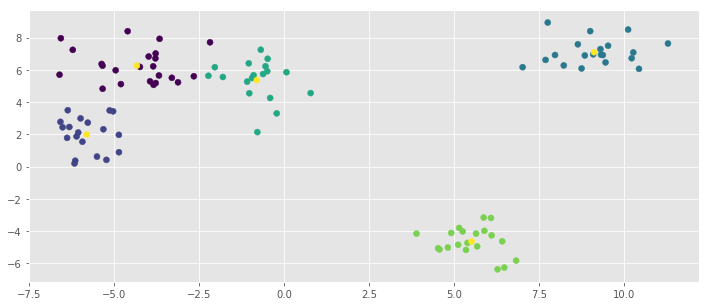

In [37]:
k = Kmeans(centers,random_state=1234)
k.fit(X,y)
dots = np.concatenate((X,k.centroids))  #  в конец массива точек дописываем центры кластеров
indices = np.array([centers for _ in xrange(0,centers)])  #  все центры выделим одним цветом
y = np.concatenate((k.labels,indices))
plt.scatter(dots[:,0], dots[:, 1], c=y)

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.

In [38]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
print df_sns.shape
df_sns.head()

(30000, 40)


,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

#### Задание 3 (4 балла)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)

In [39]:
def prepocess_sns(df):
    df = df.drop(['gradyear','gender','age','friends'], axis=1)
    for column in df.columns:
#         print "Average for column {} is {}".format(column, np.average(df.loc[:,column]))
#         print "Standard deviation is {}".format(np.std(df.loc[:,column]))
        df.loc[:,column] = (df.loc[:,column] - np.average(df.loc[:,column])) / np.std(df.loc[:,column])
    return df



In [40]:
df_sns = pd.read_csv('snsdata.csv', sep=',').head(30000)
df_sns = prepocess_sns(df_sns)
X = np.array(df_sns)
print type(X)
print X.shape
# Применяем k-means
k = Kmeans(9,random_state=5555)
k.fit(X)

<type 'numpy.ndarray'>
(30000, 36)


Kmeans(k=9, max_iter=1000, metric='euclidean', random_state=5555)

In [41]:
df_sns = pd.read_csv('snsdata.csv', sep=',').head(30000)
# df_sns = df_sns.drop(df_sns.columns[4:],axis=1)  #  Убираем информацию о ключевых словах


In [42]:
# Посмотрим на сводку по каждому кластеру
for i in xrange(0,9):
    cluster = df_sns[k.labels==i]
    print "------ Информация о кластере {} ------".format(i)
    print "Кластер содержит {} человек".format(cluster.shape[0])
    men_number = np.sum((cluster['gender']=='M').astype(int))
    women_number = np.sum((cluster['gender']=='F').astype(int))
    total = float(men_number+women_number)
    print "В кластере {} процентов мужчин и {} процентов женщин".format(men_number/total*100,women_number/total*100)
    print "У каждого человека в среднем {} друзей".format(np.nanmean(cluster['friends']))
    

------ Информация о кластере 0 ------
Кластер содержит 536 человек
В кластере 3.37301587302 процентов мужчин и 96.626984127 процентов женщин
У каждого человека в среднем 35.0205223881 друзей
------ Информация о кластере 1 ------
Кластер содержит 4519 человек
В кластере 7.38717339667 процентов мужчин и 92.6128266033 процентов женщин
У каждого человека в среднем 36.0502323523 друзей
------ Информация о кластере 2 ------
Кластер содержит 574 человек
В кластере 23.9852398524 процентов мужчин и 76.0147601476 процентов женщин
У каждого человека в среднем 32.6881533101 друзей
------ Информация о кластере 3 ------
Кластер содержит 493 человек
В кластере 0.0 процентов мужчин и 100.0 процентов женщин
У каждого человека в среднем 41.5578093306 друзей
------ Информация о кластере 4 ------
Кластер содержит 19012 человек
В кластере 21.5829456451 процентов мужчин и 78.4170543549 процентов женщин
У каждого человека в среднем 27.1421733642 друзей
------ Информация о кластере 5 ------
Кластер содержит 6